In [1]:
%load_ext autoreload
%autoreload 2

import network
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from numba import jit, int8, int32, float64

## Aufgabe 3
- Bewegung eines Moleküls durch random walk auf Quadratgitter
- Richtung ist gleichmäßig zufällig
- Abhängigkeit der mittleren quadratischen Position von der Schrittzahl?
- Was ändert sich mit selfavoiding?

- Berechnung der mittleren quadratischen Position über $$\overline{X}_m = \sqrt{\frac{1}{N}\sum_{i=1}^N \vec{x}^2_i} = \sqrt{\frac{1}{N}\sum_{i=1}^N x_i^2+y_i^2}$$

- `mid_quad_pos()` berechnet die mittlere quadratische Position für alle Schritte einer Kette als Array
- `random_walks()` erzeugt eine beliebige Anzahl an unterschiedlichen random walks mit beliebiger Schrittzahl und berechnet die mittlere quadratische Position für alle Ketten als 2D-Array

In [2]:
@jit(float64[:](int8[:,:]))
def mid_quad_pos(chain):
    result = np.zeros(len(chain), dtype=np.float64)
    a = 0
    for i in range(len(chain)):
        c = chain[i]
        a += (c[0]*c[0] + c[1]*c[1])
        result[i] = np.sqrt(a / (i+1))
    return result

@jit(float64[:,:](int32, int32))
def random_walks(n_walks, n_steps):
    y = np.zeros((n_walks, n_steps), dtype=np.float64)
    for i in range(len(y)):
        c = network.random_walk(n_steps, False, False, False)
        y[i] = mid_quad_pos(c)
    return y
    

- 1000 random walks mit je 1.000.000 Schritten
- die mittleren quadratischen Positionen werden für jeden Schritt über die 1000 random walks gemittelt

In [16]:
n_steps = 500_000
n_walks = 1000
y0 = np.average(random_walks(n_walks, n_steps), axis=0)

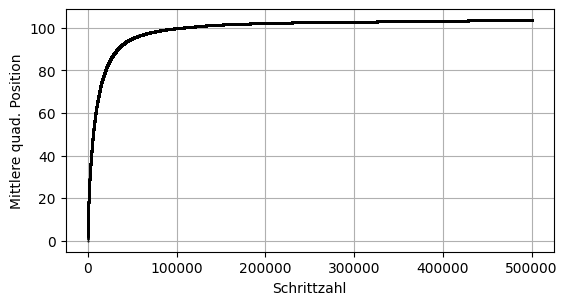

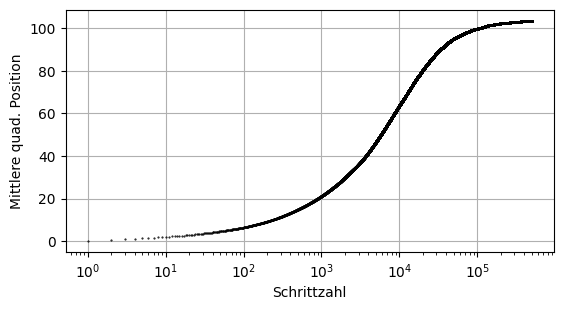

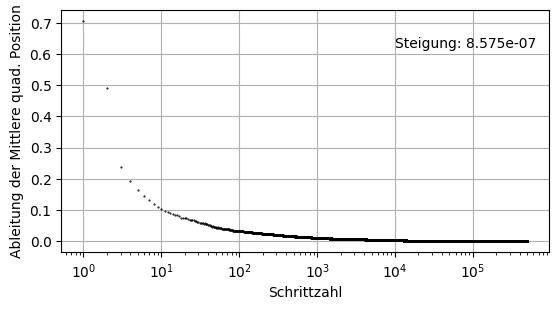

In [33]:
x = np.arange(1, n_steps + 1)
fig, ax = plt.subplots(figsize=(16/2.54, 8/2.54))
ax.plot(x, y0, '.k', markersize=1, linewidth=0.5)
ax.set_xlabel('Schrittzahl')
ax.set_ylabel('Mittlere quad. Position')
#ax.set_ylim(-10, 200)
plt.grid()

fig, ax = plt.subplots(figsize=(16/2.54, 8/2.54))
ax.plot(x, y0, '.k', markersize=1, linewidth=0.5)
ax.set_xlabel('Schrittzahl')
ax.set_ylabel('Mittlere quad. Position')
ax.set_xscale('log')
#ax.set_ylim(-10, 200)
plt.grid()

fig, ax = plt.subplots(figsize=(16/2.54, 8/2.54))
y = np.gradient(y0, 1)
ax.plot(x, y, '.k', markersize=1, linewidth=0.5)
ax.set_xlabel('Schrittzahl')
ax.set_ylabel('Ableitung der Mittlere quad. Position')
ax.set_xscale('log')
ax.text(10**4, 0.62, f'Steigung: {y[-1]:.3e}')
#ax.set_ylim(-10, 200)
plt.grid()

### Ergebnis: 
- Sehr glatte logarithmisch förmige Kurve, die aber bei großen Werten flacher wird
- Steigt kaum noch bei mitt. quad. Position von 100
- Am Ende Steigung von $8,5\cdot 10^{-7}$

- Mit selfavoiding gleiches Grundprinzip
- random walks können früher abbrechen da es keinen Platz zum Laufen gibt
- Funktion muss modifiziert werden für richtiges Mittel

In [3]:
@jit(float64[:](int32, int32))
def random_walks_sa(n_walks, n_steps):
    y = []
    for i in range(n_walks):
        c = network.random_walk(n_steps, False, True, False)
        y.append(mid_quad_pos(c))
    y0 = np.zeros(n_steps, dtype=np.float64)
    n = np.zeros(n_steps, dtype=np.int32)
    for i in range(n_steps):
        for j in range(n_walks):
            s = len(y[j])
            if i < s:
                y0[i] += y[j][i]
                n[i] += 1
    return y0 / n

In [12]:
n_steps = 500
n_walks = 1000
y0 = random_walks_sa(n_walks, n_steps)

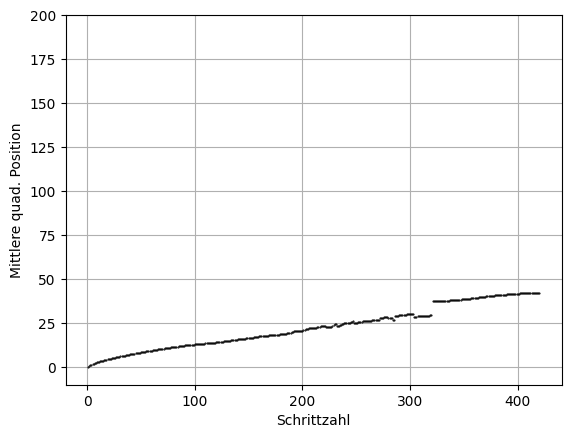

In [13]:
x = np.arange(1, n_steps + 1)
fig, ax = plt.subplots()
ax.plot(x, y0, '.k', markersize=1, linewidth=0.5)
ax.set_xlabel('Schrittzahl')
ax.set_ylabel('Mittlere quad. Position')
#ax.set_xscale('log')
ax.set_ylim(-10, 200)

#ax.plot(x, y, '--')
plt.grid()

### Ergebnis:
- Die meisten walks brechen nach weniger als 100 Schritten ab
- Nach $\approx 400$ Schritten gibt es kein random walks mehr 
- Durch sehr wenige walks nach etwa 200 Schritten ist die Kurve nicht mehr glatt